In [1]:
import torch
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
plt.style.use("mpl-config")

In [8]:
# fnames = glob("logs/*.txt")
fnames = glob("logs_before_qmean/*.txt")
fname = fnames[0]
def _get_metadata(fname):
    fname = fname.split("/")[-1]
    n_subjet, n_clusters, n_particles = fname.split("_")[1:]
    seed = int(n_particles.split("(")[1].split(")")[0])
    n_subjet, n_clusters, n_particles = int(n_subjet), int(n_clusters), int(n_particles.split("(")[0])
    return n_subjet, n_clusters, n_particles, seed
def get_metadata(fnames):
    return [_get_metadata(fname) for fname in fnames]

def parse_file(fname):
    n_subjet, n_clusters, n_particles, seed = _get_metadata(fname)
    with open(fname, "r") as f:
        header = f.readline()
        if header == "":
            print(f"Empty file: {fname}")
            # return [None] * 8
            return [None] * 7
        emd_nn, emd_true, last_emd_nn, last_emd = header.split(", ")
        emd_nn, emd_true, last_emd_nn, last_emd = float(emd_nn), float(emd_true), float(last_emd_nn), float(last_emd)
        ppq = np.loadtxt(f)
        p = ppq[:n_subjet]
        p_final = ppq[n_subjet:2*n_subjet]
        q = ppq[2*n_subjet:-n_clusters]
        # true_q_centers = ppq[-n_clusters:]
        # assert len(q) == n_clusters * n_particles, ("bad file: " + fname, len(q), n_clusters * n_particles, ppq.shape, n_clusters*n_particles + 2*n_subjet + n_clusters)
    return emd_nn, emd_true, last_emd_nn, last_emd, p, p_final, q, #true_q_centers

def make_df(fnames):
    df = pd.DataFrame(get_metadata(fnames), columns=["n_subjet", "n_clusters", "n_particles", "seed"])
    df["fname"] = fnames
    # df["emd_nn"], df["emd_true"], df["last_emd_nn"], df["last_emd"], df["p"], df["p_final"], df["q"], df["true_q_centers"] = zip(*[parse_file(fname) for fname in fnames])
    df["emd_nn"], df["emd_true"], df["last_emd_nn"], df["last_emd"], df["p"], df["p_final"], df["q"] = zip(*[parse_file(fname) for fname in fnames])
    return df

df = make_df(fnames)

Empty file: logs_before_qmean/subjet_6_6_20(65).txt


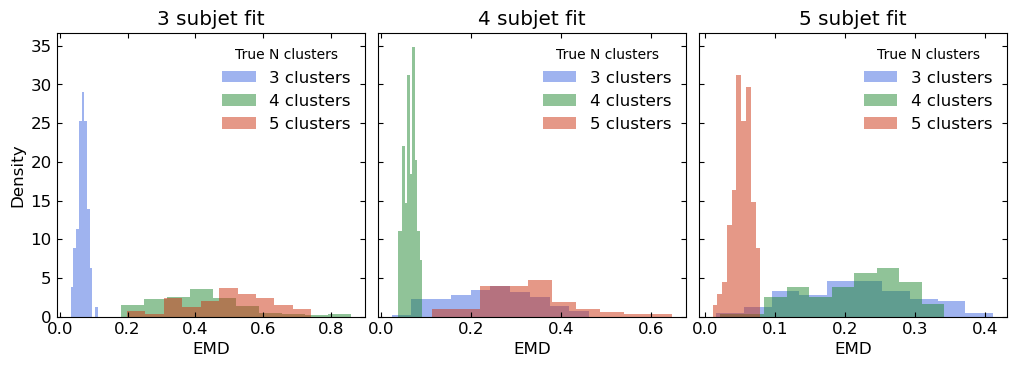

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True)
for ax, n_subjet in zip(axes.flatten(), range(3, 6)):
    for n_clusters in range(3, 6):
        emds = df[(df.n_subjet == n_subjet)&(df.n_clusters==n_clusters)&(df.n_particles==10)].last_emd_nn
        ax.hist(emds, label=f"{n_clusters} clusters", alpha=0.5, density=True)
    ax.legend(title="True N clusters")
    ax.set_title(f"{n_subjet} subjet fit")
    ax.set_xlabel("EMD")
    # ax.set_xlim(0, 1)
axes[0].set_ylabel("Density")
plt.tight_layout(pad=0.1, w_pad=0.1)
plt.savefig("subjetFitting_paper.pdf")
plt.show()

/Users/cm/opt/miniconda3/envs/main/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


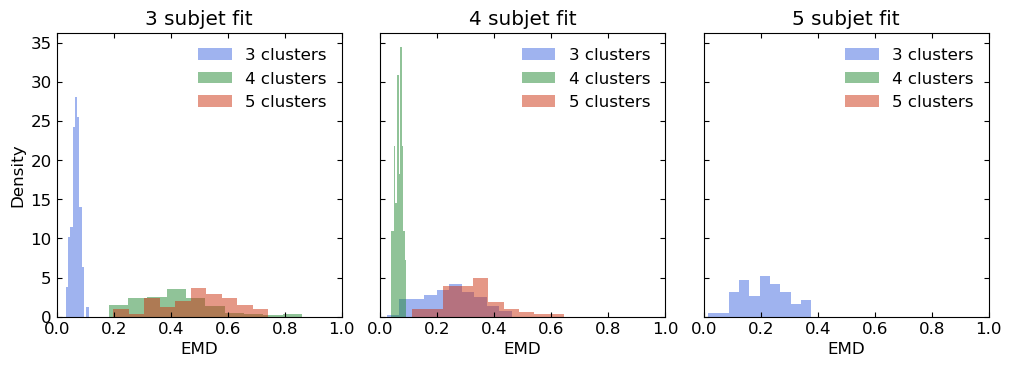

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True)
for ax, n_subjet in zip(axes.flatten(), range(3, 6)):
    for n_clusters in range(3, 6):
        emds = df[(df.n_subjet == n_subjet)&(df.n_clusters==n_clusters)&(df.n_particles==10)].last_emd_nn
        ax.hist(emds, label=f"{n_clusters} clusters", alpha=0.5, density=True)
    ax.legend()
    ax.set_title(f"{n_subjet} subjet fit")
    ax.set_xlabel("EMD")
    ax.set_xlim(0, 1)
axes[0].set_ylabel("Density")
plt.tight_layout(pad=0.1, w_pad=0.1)
plt.savefig("subjetFitting_10_new.pdf")
plt.show()

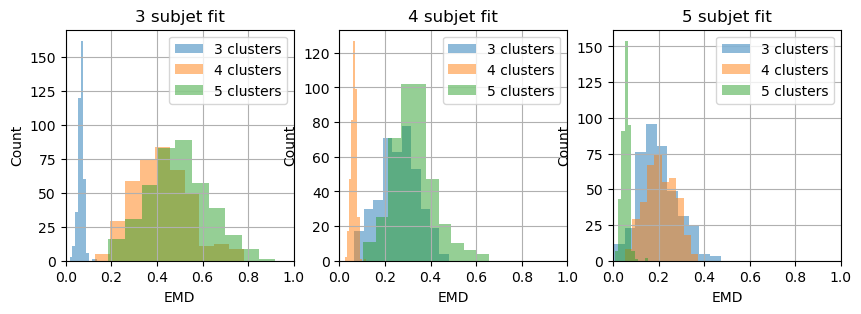

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, n_subjet in zip(axes.flatten(), range(3, 6)):
    for n_clusters in range(3, 6):
        df[(df.n_subjet == n_subjet)&(df.n_clusters==n_clusters)].last_emd_nn.hist(bins=10, alpha=0.5, label=f"{n_clusters} clusters", ax=ax)
    ax.legend()
    ax.set_title(f"{n_subjet} subjet fit")
    ax.set_xlabel("EMD")
    ax.set_ylabel("Count")
    ax.set_xlim(0, 1)
plt.show()

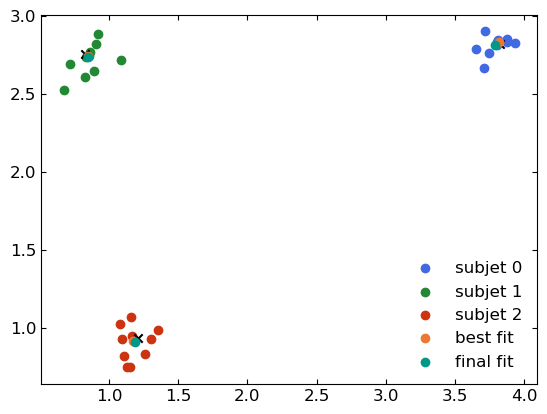

In [46]:
evt = df[df["fname"] == 'logs/subjet_3_3_10(0).txt'].iloc[0]
q = evt.q.reshape(evt.n_particles, -1, 2)
p = evt.p.reshape(-1, 2)
p_final = evt.p_final.reshape(-1, 2)
for i in range(evt.n_subjet):
    plt.scatter(q[:, i, 0], q[:, i, 1], label=f"subjet {i}")
    plt.scatter(evt.true_q_centers[i, 0], evt.true_q_centers[i, 1], marker="x", color="black")
plt.scatter(p[:, 0], p[:, 1], label="best fit")
plt.scatter(p_final[:, 0], p_final[:, 1], label="final fit")
plt.legend()

In [12]:
# Ability to reconstruct jet center
from scipy.spatial.distance import cdist
def get_center(df):
    distances = []
    distances_mle = []
    for iloc in range(len(df)):
        evt = df.iloc[iloc]
        if evt.p_final is None:
            continue
        p = evt.p_final
        q = evt.q.reshape(evt.n_particles, evt.n_clusters, 2)
        qmean = q.mean(axis=0)
        # qstd = q.std(axis=(0, 2))
        qcenter = evt.true_q_centers.reshape(evt.n_clusters, 2)
        distances.append(cdist(p, qcenter).min(axis=1))
        distances_mle.append(cdist(p, qmean).min(axis=1))
    return np.array(distances), np.array(distances_mle)
    # return 10 * np.array(distances)**2 / 0.01

/Users/cm/opt/miniconda3/envs/main/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


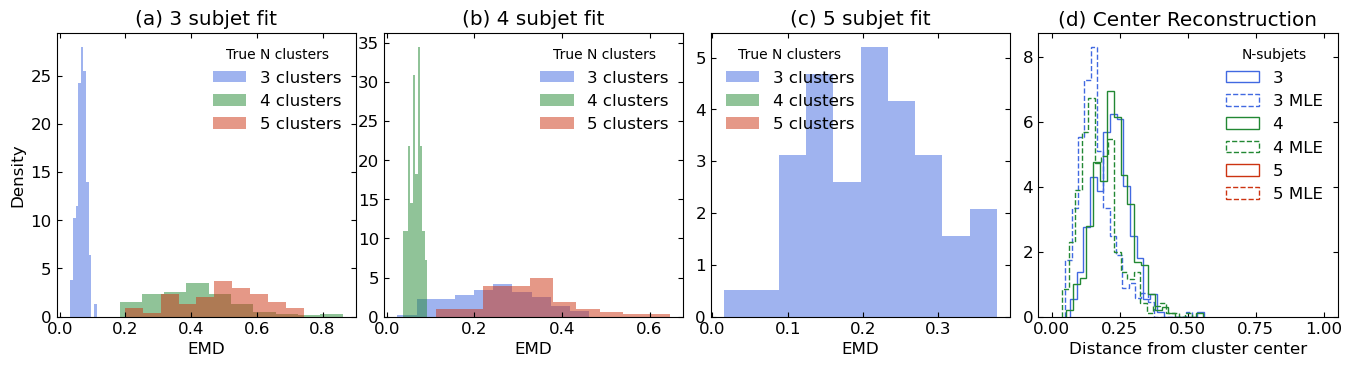

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(10/3*4, 3.5))
# fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, n_subjet in zip(axes.flatten()[:-1], range(3, 6)):
    letter = "abcdef"[n_subjet-3]
    for n_clusters in range(3, 6):
        emds = df[(df.n_subjet == n_subjet)&(df.n_clusters==n_clusters)].last_emd_nn
        ax.hist(emds, label=f"{n_clusters} clusters", alpha=0.5, density=True,)
    ax.legend(title="True N clusters")
    ax.set_title(f"({letter}) {n_subjet} subjet fit")
    ax.set_xlabel("EMD")
    # ax.set_xlim(0, 1)
    # ax.set_ylim()
axes[0].set_ylabel("Density")
# set_share_axes(axes[:-1], sharey=True)
ax = axes[-1]
for n in range(3, 6):
    distances, distances_mle = get_center(df[(df.n_subjet==n) & (df.n_clusters==n)&((df.n_particles==10))])
    plt.hist(np.sqrt(distances.flatten()), bins=20, alpha=1, label=f"{n}", density=True, histtype="step", color=f"C{n-3}")
    plt.hist(np.sqrt(distances_mle.flatten()), bins=20, alpha=1, label=f"{n} MLE", density=True, histtype="step", ls="--", color=f"C{n-3}")
# ax.set_xscale("log")
# ax.axvline(0.1*np.sqrt(2)/np.sqrt(10), color="k", linestyle="--", label="resolution")
# get chi2 distribution

# set legend to center
# ax.legend(title="N-subjets", loc="center", bbox_to_anchor=(0.5, 0.75))
ax.legend(title="N-subjets")
ax.set_title("(d) Center Reconstruction")
ax.set_xlabel("Distance from cluster center")
# ax.set_ylabel("Count")
plt.tight_layout(pad=0.1, w_pad=0.1)
plt.savefig("subjetFittingDistance_10_new.pdf")
plt.show()

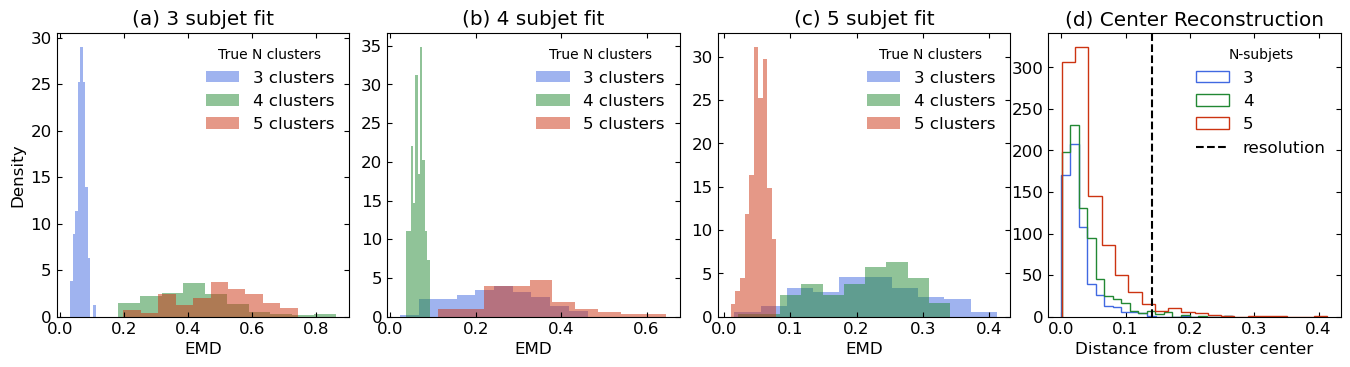

In [11]:
# fig, axes = plt.subplots(1, 4, figsize=(10/3*4, 3.5))
# # fig, axes = plt.subplots(1, 3, figsize=(10, 3))
# for ax, n_subjet in zip(axes.flatten()[:-1], range(3, 6)):
#     letter = "abcdef"[n_subjet-3]
#     for n_clusters in range(3, 6):
#         emds = df[(df.n_subjet == n_subjet)&(df.n_clusters==n_clusters)&((df.n_particles==10))].last_emd_nn
#         ax.hist(emds, label=f"{n_clusters} clusters", alpha=0.5, density=True,)
#     ax.legend(title="True N clusters")
#     ax.set_title(f"({letter}) {n_subjet} subjet fit")
#     ax.set_xlabel("EMD")
#     # ax.set_xlim(0, 1)
#     # ax.set_ylim()
# axes[0].set_ylabel("Density")
# # set_share_axes(axes[:-1], sharey=True)
# ax = axes[-1]
# for n in range(3, 6):
#     distances = get_center(df[(df.n_subjet==n) & (df.n_clusters==n)])
#     plt.hist(distances.flatten(), bins=20, alpha=1, label=f"{n}", density=True, histtype="step")
# ax.axvline(0.1*np.sqrt(2), color="k", linestyle="--", label="resolution")
# # set legend to center
# # ax.legend(title="N-subjets", loc="center", bbox_to_anchor=(0.5, 0.75))
# ax.legend(title="N-subjets")
# ax.set_title("(d) Center Reconstruction")
# ax.set_xlabel("Distance from cluster center")
# # ax.set_ylabel("Count")
# plt.tight_layout(pad=0.1, w_pad=0.1)
# plt.savefig("subjetFittingDistance.pdf")
# plt.show()